https://github.com/Kabanosk/whisper-website
https://github.com/openai/whisper/discussions/264

In [ ]:
# %%capture
# %pip install python-dotenv

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import yt_dlp
import unzip
from typing import List, Callable, Optional, Dict

# increase column width
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', None)

# Download Audio and Transcribe

In [2]:
VIDEO_URL = "https://youtu.be/DgTjSrrf6GQ"
AUDIO_FILE_NAME = "./data/audio/Lex_Podcast.mp3"
AUDIO_QUALITY = 5 # 0 best - 10 worst (default 5)
AUDIO_FORMAT = "mp3"
FFMPEG_LOCATION = "ffmpeg-master-latest-win64-gpl/bin"
SUBTITLE_LANGUAGE = "en.*"
TRANSCRIPT_FILE_NAME = "./data/transcript.txt"
SUBTITLE_FORMAT = "srt"

In [ ]:
import wget
import os
import zipfile

FFMPEG_URL = 'https://github.com/yt-dlp/FFmpeg-Builds/releases/download/latest/ffmpeg-master-latest-win64-gpl.zip'
ZIP_PATH = './ffmpeg.zip'
EXTRACT_DIR = './'

if not os.path.exists(ZIP_PATH):
    print('Downloading ffmpeg...')
    wget.download(FFMPEG_URL, ZIP_PATH)

    print('Unzipping...') 
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    
    print('Removing zip file...')
    os.remove(ZIP_PATH)

else:
    print('Already downloaded.')

In [ ]:
!yt-dlp -xv --ffmpeg-location ffmpeg-master-latest-win64-gpl/bin --audio-format mp3  -o data/audio/Lex_Podcast -- {"https://youtu.be/DEu24V8vfb8"}
#!yt-dlp -xv --ffmpeg-location {FFMPEG_LOCATION} --audio-format {AUDIO_FORMAT}  -o {AUDIO_FILE_NAME} -- {"https://youtu.be/DEu24V8vfb8"}

In [ ]:
import openai
from dotenv import load_dotenv, find_dotenv
import os

_ = load_dotenv(find_dotenv())  # add .env to .gitignore
openai.api_key = os.getenv("OPENAI_API_KEY")


In [ ]:
audio_file = open("data/audio/Lexicap.mp3", "rb")
transcript = openai.Audio.transcribe("whisper-1", audio_file, response_format=SUBTITLE_FORMAT)

In [ ]:
# with open("langchain.srt", "w") as f:
#     f.write(transcript)

## Longer Inputs
By default, the Whisper API only supports files that are less than 25 MB. If you have an audio file that is longer than that, you will need to break it up into chunks of 25 MB's or less or used a compressed audio format. To get the best performance, we suggest that you avoid breaking the audio up mid-sentence as this may cause some context to be lost.

One way to handle this is to use the [PyDub open source Python package](https://github.com/jiaaro/pydub) to split the audio:

In [ ]:
from pydub import AudioSegment

song = AudioSegment.from_mp3("good_morning.mp3")

# PyDub handles time in milliseconds
ten_minutes = 10 * 60 * 1000

first_10_minutes = song[:ten_minutes]

first_10_minutes.export("good_morning_10.mp3", format="mp3")

### Prompting
* Check out [OpenAI](https://platform.openai.com/docs/guides/speech-to-text/prompting)

# Download Transcript

In [ ]:
# Download the transcript with yt-dlp
!yt-dlp --write-auto-sub --skip-download --sub-format {SUBTITLE_FORMAT} --sub-lang {SUBTITLE_LANGUAGE} --output {TRANSCRIPT_FILE_NAME} -- {VIDEO_URL}

## Data Preparation
Let's change the name of the raw caption files:

In [ ]:
# Get a clean list of podcast titles
import re 

def clean_titles(title):
    title = re.sub(r'\[(.*?)\]\((.*?)\)', r'\1', title)
    title = re.sub(r'\|.*?\d+', '', title)
    title = title.rstrip().replace(' ', '_').replace(':', '_').replace('&','and').lower()
    title = re.sub(r'[^a-zA-Z0-9_]', '', title)
    return title

with open('./data/Lexicap.md', 'r') as f:
    text = f.read()

titles = text.split('\n')
titles = [clean_titles(title) for title in titles if title != '']

In [ ]:
# Rename the transcript files
import os

TRANSCRIPT_PATH = "./data/transcripts/"
FILE_EXTENSION = '.vtt'

for org_filename, line_idx in zip(os.listdir(path=TRANSCRIPT_PATH), titles):
    if org_filename.endswith(FILE_EXTENSION):
        print(org_filename)
        # rename file 
        new_filename = f"{line_idx}{FILE_EXTENSION}"
        os.rename(f"{TRANSCRIPT_PATH}{org_filename}", f"{TRANSCRIPT_PATH}{new_filename}")

# Start
### Data Cleaning

In [3]:
TRANSCRIPT_PATH = "./data/transcripts/"
FILE_EXTENSION = '.vtt'

In [4]:
# Create new transcript file with timestamp and text
TRANSCRIPT_FILE_NAME = "45_michio_kaku__future_of_humans_aliens_space_travel_and_physics.vtt"
NEW_TRANSCRIPT_FILE_NAME = "45_michio_kaku__future_of_humans_aliens_space_travel_and_physics.csv"


with open(f"{TRANSCRIPT_PATH}{TRANSCRIPT_FILE_NAME}") as oldfile, open(f"{NEW_TRANSCRIPT_FILE_NAME}", 'w') as newfile:
    old_lines = oldfile.read().split('\n')
    clean_lines = [line for line in old_lines if line not in ['', 'WEBVTT']]

    for line_idx in range(0, len(clean_lines)-1, 2):
         timestamp = clean_lines[line_idx].split('-->')[0].strip()
         # Standardize timestamp format
         timestamp = "00:" + timestamp if len(timestamp.split(':')) < 3 else timestamp
         timestamp = "0" + timestamp if len(timestamp.split(':')[0]) < 2 else timestamp
         text = clean_lines[line_idx+1].rstrip()
         new_line = f"{timestamp};{text}\n"
         newfile.write(new_line)


In [5]:
df = pd.read_csv(f"{NEW_TRANSCRIPT_FILE_NAME}"
                            ,sep=';', 
                            header=None, names=['timestamp', 'text'],)
df.head(25)

,timestamp,text
0,00:00:00.000,The following is a conversation with Michio Kaku.
1,00:00:02.800,"He's a theoretical physicist, futurist,"
2,00:00:05.120,and professor at the City College of New York.
3,00:00:08.360,He's the author of many fascinating books
4,00:00:10.760,that explore the nature of our reality
5,00:00:12.840,and the future of our civilization.
6,00:00:15.520,"They include Einstein's Cosmos, Physics of the Impossible,"
7,00:00:19.200,"Future of the Mind, Parallel Worlds,"
8,00:00:21.600,"and his latest, The Future of Humanity,"
9,00:00:24.240,"Terraforming Mars Interstellar Travel,"


* Since Whisper has not skipped the punctuations in the transcript, we can reconstruct full sentences, ensuring that each sentence is ended with a period `.`

In [6]:
# Recreate the dataframe with full sentences
transcript_df = pd.DataFrame(columns=df.columns)

for idx, timestamp, text in df.itertuples():
    while text[-1] != '.':
        idx += 1
        text += df.loc[idx]['text']
    transcript_df = pd.concat([transcript_df, pd.DataFrame({'timestamp': timestamp, 'text': text}, index=[0])], ignore_index=True)

# Remove any piece of text if it is included in previous text
not_part_of_previous = [True]
for i in range(1, len(transcript_df)):
    not_part_of_previous.append(transcript_df['text'][i] not in transcript_df['text'][i-1])
transcript_df = transcript_df[not_part_of_previous] 


# 1. NER
* Add column for persons, orginazations, books, companies, countries, places.

## Mentioned Books

In [7]:
#%%capture
# %pip install -U spaCy
# %pip install 'spacy[transformers]'
#!python -m spacy download en_core_web_trf # download best-matching version of specific model

In [8]:
import spacy
# load a pipeline package by name and return nlp object
nlp = spacy.load("en_core_web_trf", disable=["tok2vec","parser"]) #disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer", "ner"]

# check processing pipeline components of nlp object
nlp.pipeline


[('transformer',
  <spacy_transformers.pipeline_component.Transformer at 0x17e9ae574c0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x17e9ae565c0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x17e9af559c0>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x17e9ae6fc80>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x17e9ae49540>)]

In [9]:
# create a Doc by processing a string of text with the nlp object
doc = nlp("So I'm with Jared Diamond, you know, in the book Collapse, \
          where he points out studying the collapse of major civilizations, \
          that it often happens right after things appear to never have been better. Hmm.")


# iterate over tokens in a Doc
print("Entities: ", [e.text for e in doc.ents if e.label_ == 'WORK_OF_ART'])


Entities:  ['Collapse']


In [10]:
# Find book related sentences in the transcript
book_related_phrases = [
    "book", "books", "i read", 
    "everyone should read", "you should read", "he wrote a novel",
    "i recommend", "highly recommend", "you must read", 
    "shouldn't miss", "top books", "best books", 
    "favorite book", "my favorite books", "book you need to read",
    "books to read before", "essential books", "great book for",
    "worthy read", "book of the year", "award winning book"
]




def contains_book_phrase(text: str, search_list: List[str]) -> bool:
    """
    Check if a text contains any of a list of book-related phrases.

    :param text: The text to search within.
    :param search_list: A list of phrases to search for.
    :return: True if any phrase is found in the text, False otherwise.
    """
    return any(phrase in text.lower() for phrase in search_list)


transcript_df["is_book_related"] = transcript_df["text"].apply(contains_book_phrase, search_list=book_related_phrases)

In [11]:
def get_book_titles_candidates(text: str, pipeline: Callable[[str], 'Doc']) -> List[str]:
    """
    Extract potential book titles from a text using a given NLP model.

    :param text: The text to extract titles from.
    :param pipeline: The NLP model to use for text processing.
    :return: A list of potential book titles.
    """
    doc = nlp(text)
    book_titles_candidates = [entity.text for entity in doc.ents if entity.label_ == 'WORK_OF_ART']
    return book_titles_candidates


In [12]:
transcript_df.query("is_book_related == True")["text"].apply(get_book_titles_candidates,
                                                                  pipeline=nlp)

3                               []
182                             []
341                             []
478       [The Future of the Mind]
638                             []
859                             []
940                             []
954     [The Theory of Everything]
957                             []
1149          [Future of Humanity]
Name: text, dtype: object

In [13]:
# Add book candidates to the dataframe
transcript_df["book_candidates"] = transcript_df.apply(lambda x: get_book_titles_candidates(x["text"], pipeline=nlp) \
                                                                 if x["is_book_related"] else [], axis=1)

In [14]:
transcript_df.query("is_book_related == True")

,timestamp,text,is_book_related,book_candidates
3,00:00:08.360,He's the author of many fascinating books that explore the nature of our reality and the future of our civilization.,True,[]
182,00:08:30.920,"And Stephen Hawking, for example, even in his last book, even said that this is an argument against the existence of God.",True,[]
341,00:16:04.760,"If you read the book, the aliens did not have evil intentions toward homo sapiens.",True,[]
478,00:22:38.600,"I have a book, The Future of the Mind, where I detail some of these breakthroughs.",True,[The Future of the Mind]
638,00:29:54.080,"Our ancestors were lucky if they had one line, just one line in a church book, saying the date they were baptized and the date they died.",True,[]
859,00:40:07.240,"For Isidor Rabi, it was a book about the planets.",True,[]
940,00:44:06.200,"That desk had a book on it, which was opened.",True,[]
954,00:44:43.160,"And then over the years, I found out the guy had a name, Albert Einstein, and that book was The Theory of Everything.",True,[The Theory of Everything]
957,00:44:53.080,"Well, today I can read that book.",True,[]
1149,00:53:36.600,"And in my book, Future of Humanity, I even speculate beyond that, that by the end of this century, we'll probably have the first starships.",True,[Future of Humanity]


In [15]:
import requests
from typing import Optional, Dict

def get_book_info(title: str) -> Optional[Dict]:
    """
    Fetch book information from Google Books API.

    :param title: The title of the book to search for.
    :return: A dictionary containing book information if found, None otherwise.
    """
    try:
        response = requests.get(f"https://www.googleapis.com/books/v1/volumes?q={title}")

        # Raise an exception if the request was unsuccessful
        response.raise_for_status()

    except requests.HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
        return None
    except Exception as err:
        print(f'Other error occurred: {err}')
        return None

    else:
        data = response.json()
        most_rated_book = None
        # Find popular book (highest ratings count)
        max_ratings_count = -1
        for book in data["items"]:
            ratings_count = book["volumeInfo"].get("ratingsCount", 0)
            if ratings_count > max_ratings_count:
                max_ratings_count = ratings_count
                most_rated_book = book

        if most_rated_book is None:
            return None

    return most_rated_book["volumeInfo"]
# ["Einstein's Cosmos",
#  'Physics of the Impossible',
#  'Future of the Mind',
#  'Parallel Worlds',
#  'Future of Humanity',
#  'Terraforming Mars Interstellar Travel']
get_book_info('Parallel Worlds')


{'title': 'The Hidden Reality',
 'subtitle': 'Parallel Universes and the Deep Laws of the Cosmos',
 'authors': ['Brian Greene'],
 'publisher': 'Penguin UK',
 'publishedDate': '2011-06-09',
 'description': "In this exhilarating new book, Brian Greene explores our most current understanding of the universe, its deepest laws of nature, and our continuing quest to know more. The Hidden Reality reveals how major developments in different branches of fundamental theoretical physics-relativistic, quantum, cosmological, unified, computational - have all led us to consider one or another variety of parallel universe. In some, they are separated from us by enormous stretches of space or time, in others they're hovering millimetres away, in others still the very notion of their location proves to be a concept beyond our reach. Most extraordinarily, Greene shows how all of these parallel universe proposals emerge unbidden from the mathematics of theories developed to explain conventional data and 

## Identify Other Entities

In [17]:
# %%capture
# %pip install textacy

In [16]:
import textacy

entity_types = ['PERSON', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'NORP', 'WORK_OF_ART', 'LAW']

from typing import List, Optional, Union
from spacy.tokens import Doc

def extract_entities(doc: Doc, 
                     include_types: Optional[Union[str, List[str]]] = None, 
                     sep: str = ' ') -> List[str]:
    """
    Extract named entities from a document and return them as strings.

    :param doc: The document to extract entities from.
    :param include_types: The types of entities to include. If None, include all types.
    :param sep: The separator to use when joining lemmas of multi-token entities.
    :return: A list of named entities in the form 'lemma/label'.
    """
    ents = textacy.extract.entities(doc, 
                                    include_types=include_types, 
                                    exclude_types=None, 
                                    drop_determiners=True, 
                                    min_freq=1)
    
    return [sep.join([token.text for token in entity])+'/'+entity.label_ for entity in ents]

* When processing large volumes of text, it is recommended to use spaCys batch processing for a significant performance gain. The function `nlp.pipeline` takes an iterable of texts, processes them internally as batch, and yields a list fo processed Doc objects in the same order as the input data.
* To use `nlp.pipeline`, we first have to define a batch size. Then we can loop over the batches and call `nlp.pipe`. In the inner loop we extract the features from the processed doc and write the values back into the a list:

In [17]:
# Extract entities from the transcript
import numpy as np
from tqdm import tqdm

batch_size = 50
batches = np.ceil(len(transcript_df) / batch_size).astype(int)

named_entities = []

# loop over batches, step size is equal to batch size
for i in tqdm(range(0, len(transcript_df), batch_size), total=batches):
    docs = nlp.pipe(transcript_df['text'][i:i+batch_size])
    
    for doc in docs:
        named_entities.append(extract_entities(doc, include_types=entity_types)) 

transcript_df['named_entities'] = named_entities 

100%|██████████| 13/13 [00:53<00:00,  4.13s/it]


In [18]:
# Add columns for each entity type
for ent_type in entity_types:
    transcript_df[ent_type.lower()] = transcript_df["named_entities"].apply(lambda x: \
                                                                            [entity.split('/')[0] for entity in x if entity.split('/')[1] == ent_type])

In [19]:
transcript_df.head(2)

,timestamp,text,is_book_related,book_candidates,named_entities,person,org,gpe,loc,product,event,norp,work_of_art,law
0,00:00:00.000,The following is a conversation with Michio Kaku.,False,[],[Michio Kaku/PERSON],[Michio Kaku],[],[],[],[],[],[],[],[]
1,00:00:02.800,"He's a theoretical physicist, futurist, and professor at the City College of New York.",False,[],[City College of New York/ORG],[],[City College of New York],[],[],[],[],[],[],[]


In [20]:
def contains_empty_list(df: pd.DataFrame, col_name: str) -> bool:
    """
    Check if a column in a DataFrame contains any empty lists.

    :param df: The DataFrame to check.
    :param col_name: The name of the column to check.
    :return: True if any empty list is found, False otherwise.
    """
    return df[col_name].apply(lambda x: x == []).any()


# Find columns with empty lists
cols_to_clean = [col for col in transcript_df.columns if contains_empty_list(transcript_df, col)]

# Remove empty lists 
for ent_type in cols_to_clean:
    transcript_df[ent_type] = transcript_df[ent_type].apply(lambda x: x if len(x) > 0 else None)

In [21]:
from collections import Counter 
import pandas as pd
from typing import Optional, Callable

def count_words(dataframe: pd.DataFrame, 
                column: str, 
                preprocess: Optional[Callable[[str], str]] = None, 
                min_frequency: int = 1) -> pd.DataFrame:
    """
    Count words in a specific column of a DataFrame.

    :param dataframe: The DataFrame to count words from.
    :param column: The column to count words in. Should be tokenized.
    :param preprocess: An optional function to preprocess the words before counting.
    :param min_frequency: The minimum frequency for a word to be included in the output.
    :return: A DataFrame sorted by word frequency, containing words and their frequencies.
    """
    word_counter = Counter()

    # If a preprocessing function is provided, apply it before counting words
    if preprocess:
        dataframe[column].map(lambda doc: word_counter.update(preprocess(doc)))
    else:
        dataframe[column].map(word_counter.update)

    # Convert Counter to DataFrame
    word_freq_df = pd.DataFrame.from_dict(word_counter, orient='index', columns=['freq'])
    
    # Filter words by minimum frequency
    word_freq_df = word_freq_df.query('freq >= @min_frequency')
    
    # Set index name for the dataframe
    word_freq_df.index.name = column

    # Sort DataFrame by frequency
    return word_freq_df.sort_values('freq', ascending=False)


In [22]:
# %%capture
# %pip install WordCloud

In [23]:
from wordcloud import WordCloud 
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

def generate_word_cloud(data: pd.DataFrame,
                        col_name: str, 
                        max_words: int = 200) -> None:
    """
    Generate a word cloud from word frequencies.

    :param data: A pandas DataFrame containing text data.
    :param col_name: The column name to count words from.
    :param max_words: The maximum number of words in the word cloud.
    """
    word_frequencies = count_words(data, col_name).freq

    # Convert pandas Series to Counter object
    word_frequencies = Counter(word_frequencies.fillna(0).to_dict())

    # Create wordcloud object
    word_cloud = WordCloud(width=800, height=400, 
                           background_color= "black", colormap="Paired", 
                           max_font_size=150, max_words=max_words)

    # Generate word cloud image from frequencies
    word_cloud.generate_from_frequencies(word_frequencies)

    # Display the cloud using matplotlib 
    plt.title(col_name.capitalize()) 
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")


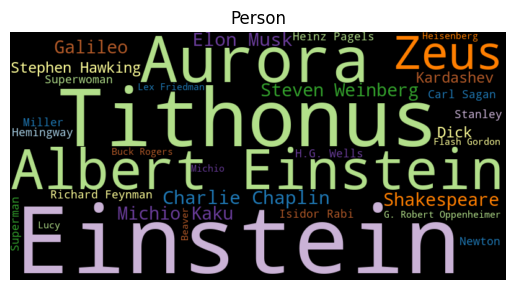

In [24]:
generate_word_cloud(transcript_df, 'person')

In [25]:
transcript_df.head(2)

,timestamp,text,is_book_related,book_candidates,named_entities,person,org,gpe,loc,product,event,norp,work_of_art,law
0,00:00:00.000,The following is a conversation with Michio Kaku.,False,None,[Michio Kaku/PERSON],[Michio Kaku],None,None,None,None,None,None,None,None
1,00:00:02.800,"He's a theoretical physicist, futurist, and professor at the City College of New York.",False,None,[City College of New York/ORG],None,[City College of New York],None,None,None,None,None,None,None


# Q&A
## Prepare the data:

For further use in text summariztion and topic modelling:

In [181]:
TRANSCRIPT_CSV_FILE = "data\michio_kaku_transcript_topic.csv"
transcript_df['group'] = transcript_df.index // 8
transcript_df_topic = transcript_df.groupby('group').agg({
    'timestamp': 'first',
    'text': ' '.join
})
transcript_df_topic.to_csv(TRANSCRIPT_CSV_FILE, index=False)

For question answering and book identification:

In [26]:
transcript_df['group'] = transcript_df.index // 20
grouped_transcript_df = transcript_df.groupby('group').agg({
    'timestamp': 'first',
    'text': ' '.join,
    'is_book_related': 'any',
    'book_candidates': 'sum',
    'named_entities': 'sum',
    
})

I will add a new column with that contains identified named-entities in plain text. First, let's create a column with entity dict:

In [27]:
def entities_to_dict(entities):
    """
    This function takes a list of entities in the format "entity/ENTITY_TYPE" and returns a dictionary
    where the keys are entity types and the values are lists of entities of that type.

    Parameters:
    entities (list): The input list of entity strings to be processed. Each entity string should be in the format
                     "entity/ENTITY_TYPE". 

    Returns:
    dict: A dictionary where the keys are descriptions of entity types (as strings), and the values are lists of 
          entities (as strings) of the corresponding type. If the input is not a list, returns an empty dictionary.
    """

    # Define a mapping from entity types to their descriptions
    # entity_type_mapping = {
    #     'PERSON': 'People, including fictional',
    #     'NORP': 'Nationalities or religious or political groups',
    #     'ORG': 'Companies, agencies, and institutions',
    #     'GPE': 'Countries, cities, and states',
    #     'LOC': 'Non-GPE locations, mountain ranges, bodies of water',
    #     'PRODUCT': 'Objects, vehicles, foods, etc. (Not services)',
    #     'EVENT': 'Named hurricanes, battles, wars, sports events, etc',
    #     'WORK_OF_ART': 'Titles of books, songs, etc',
    #     'LAW': 'Named documents made into laws',
    # }


    if not isinstance(entities, list):
        return {}

    entities_by_type = {}
    for entity in entities:
        name, entity_type = entity.split('/')
        #Use the mapping to change the keys
        # entity_type = entity_type_mapping.get(entity_type, entity_type)
        if entity_type not in entities_by_type:
            entities_by_type[entity_type] = []
        entities_by_type[entity_type].append(name)
    return entities_by_type


In [28]:
# Apply the helper function
grouped_transcript_df['named_entities_dict'] = grouped_transcript_df['named_entities'].apply(entities_to_dict)

In [29]:
grouped_transcript_df.head(2)

,timestamp,text,is_book_related,book_candidates,named_entities,named_entities_dict
group,,,,,,
0,00:00:00.000,"The following is a conversation with Michio Kaku. He's a theoretical physicist, futurist, and professor at the City College of New York. He's the author of many fascinating books that explore the nature of our reality and the future of our civilization. They include Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, and his latest, The Future of Humanity, Terraforming Mars Interstellar Travel, Immortality, and Our Destiny Beyond Earth. I think it's beautiful and important when a scientific mind can fearlessly explore through conversation subjects just outside of our understanding. That, to me, is where artificial intelligence is today, just outside of our understanding, a place we have to reach for if we're to uncover the mysteries of the human mind and build human level and superhuman level AI systems that transform our world for the better.",True,0,"[Michio Kaku/PERSON, City College of New York/ORG, Einstein/PERSON, Cosmos/WORK_OF_ART, Physics of the Impossible/WORK_OF_ART, Future of the Mind/WORK_OF_ART, Parallel Worlds/WORK_OF_ART, Future of Humanity/WORK_OF_ART, Terraforming Mars Interstellar Travel/WORK_OF_ART]","{'PERSON': ['Michio Kaku', 'Einstein'], 'ORG': ['City College of New York'], 'WORK_OF_ART': ['Cosmos', 'Physics of the Impossible', 'Future of the Mind', 'Parallel Worlds', 'Future of Humanity', 'Terraforming Mars Interstellar Travel']}"
1,00:00:56.640,"This is the Artificial Intelligence Podcast. If you enjoy it, subscribe on YouTube, give it five stars on iTunes, support it on Patreon, or simply connect with me on Twitter at Lex Friedman, spelled F R I D M A N. And now, here's my conversation with Michio Kaku. You've mentioned that we just might make contact with aliens or at least hear from them within this century. Can you elaborate on your intuition behind that optimism? Well, this is pure speculation, of course. Of course. Given the fact that we've already identified 4,000 exoplanets orbiting other stars, and we have a census of the Milky Way galaxy for the first time, we know that on average, every single star, on average, has a planet going around it, and about one fifth or so of them have Earth sized planets going around them.",False,0,"[Artificial Intelligence Podcast/ORG, YouTube/ORG, iTunes/ORG, Lex Friedman/PERSON, Michio Kaku/PERSON, Milky Way/LOC, Earth/LOC]","{'ORG': ['Artificial Intelligence Podcast', 'YouTube', 'iTunes'], 'PERSON': ['Lex Friedman', 'Michio Kaku'], 'LOC': ['Milky Way', 'Earth']}"


In [30]:
# Convert list to string separated by commas
def list_to_str(lst):
    """
    This function takes a list of strings and converts it into a single string, with elements separated by commas.

    Parameters:
    lst (list or str): The input list or string to be formatted.

    Returns:
    str: The formatted string if the input is a list of strings, otherwise the input itself.
    """
    if isinstance(lst, list):
        if len(lst) > 1:
            return ', '.join(lst[:-1]) + ', and ' + lst[-1]
        elif lst:
            return lst[0]
    return lst

# Then generate the new 'named_entities' column
def entities_plain_txt(row):
    """
    Converts a dictionary of entity types and entities into a plain text.

    Parameters:
    row (dict): Dictionary where keys are entity types and values are lists of entities.

    Returns:
    str: A formatted string that lists each entity type and its entities.
    """
    output = ""
    for entity_type, entities in row.items():
        entities_str = list_to_str(entities)
        output += f'{entity_type.title()}: {entities_str}\n'
    return output

In [31]:
grouped_transcript_df['named_entities'] = grouped_transcript_df['named_entities_dict'].apply(entities_plain_txt)

In [32]:
grouped_transcript_df.head(2)

,timestamp,text,is_book_related,book_candidates,named_entities,named_entities_dict
group,,,,,,
0,00:00:00.000,"The following is a conversation with Michio Kaku. He's a theoretical physicist, futurist, and professor at the City College of New York. He's the author of many fascinating books that explore the nature of our reality and the future of our civilization. They include Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, and his latest, The Future of Humanity, Terraforming Mars Interstellar Travel, Immortality, and Our Destiny Beyond Earth. I think it's beautiful and important when a scientific mind can fearlessly explore through conversation subjects just outside of our understanding. That, to me, is where artificial intelligence is today, just outside of our understanding, a place we have to reach for if we're to uncover the mysteries of the human mind and build human level and superhuman level AI systems that transform our world for the better.",True,0,"Person: Michio Kaku, and Einstein\nOrg: City College of New York\nWork_Of_Art: Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, Future of Humanity, and Terraforming Mars Interstellar Travel\n","{'PERSON': ['Michio Kaku', 'Einstein'], 'ORG': ['City College of New York'], 'WORK_OF_ART': ['Cosmos', 'Physics of the Impossible', 'Future of the Mind', 'Parallel Worlds', 'Future of Humanity', 'Terraforming Mars Interstellar Travel']}"
1,00:00:56.640,"This is the Artificial Intelligence Podcast. If you enjoy it, subscribe on YouTube, give it five stars on iTunes, support it on Patreon, or simply connect with me on Twitter at Lex Friedman, spelled F R I D M A N. And now, here's my conversation with Michio Kaku. You've mentioned that we just might make contact with aliens or at least hear from them within this century. Can you elaborate on your intuition behind that optimism? Well, this is pure speculation, of course. Of course. Given the fact that we've already identified 4,000 exoplanets orbiting other stars, and we have a census of the Milky Way galaxy for the first time, we know that on average, every single star, on average, has a planet going around it, and about one fifth or so of them have Earth sized planets going around them.",False,0,"Org: Artificial Intelligence Podcast, YouTube, and iTunes\nPerson: Lex Friedman, and Michio Kaku\nLoc: Milky Way, and Earth\n","{'ORG': ['Artificial Intelligence Podcast', 'YouTube', 'iTunes'], 'PERSON': ['Lex Friedman', 'Michio Kaku'], 'LOC': ['Milky Way', 'Earth']}"


In [38]:
# Concatenate text, named entities, and book candidates into a single column
final_text = grouped_transcript_df.apply(lambda row: f"{row['text']}\n\n" \
                                            f"Named Entities:\n{row['named_entities']}\n\n", axis=1)


# creating the new DataFrame
df_final = pd.DataFrame({
    'timestamp': grouped_transcript_df['timestamp'],
    'text': final_text
})

#df_final = grouped_transcript_df[['timestamp', 'text', 'named_entities']].copy()

In [39]:
df_final.head(2)

,timestamp,text
group,,
0,00:00:00.000,"The following is a conversation with Michio Kaku. He's a theoretical physicist, futurist, and professor at the City College of New York. He's the author of many fascinating books that explore the nature of our reality and the future of our civilization. They include Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, and his latest, The Future of Humanity, Terraforming Mars Interstellar Travel, Immortality, and Our Destiny Beyond Earth. I think it's beautiful and important when a scientific mind can fearlessly explore through conversation subjects just outside of our understanding. That, to me, is where artificial intelligence is today, just outside of our understanding, a place we have to reach for if we're to uncover the mysteries of the human mind and build human level and superhuman level AI systems that transform our world for the better.\n\nNamed Entities:\nPerson: Michio Kaku, and Einstein\nOrg: City College of New York\nWork_Of_Art: Cosm..."
1,00:00:56.640,"This is the Artificial Intelligence Podcast. If you enjoy it, subscribe on YouTube, give it five stars on iTunes, support it on Patreon, or simply connect with me on Twitter at Lex Friedman, spelled F R I D M A N. And now, here's my conversation with Michio Kaku. You've mentioned that we just might make contact with aliens or at least hear from them within this century. Can you elaborate on your intuition behind that optimism? Well, this is pure speculation, of course. Of course. Given the fact that we've already identified 4,000 exoplanets orbiting other stars, and we have a census of the Milky Way galaxy for the first time, we know that on average, every single star, on average, has a planet going around it, and about one fifth or so of them have Earth sized planets going around them.\n\nNamed Entities:\nOrg: Artificial Intelligence Podcast, YouTube, and iTunes\nPerson: Lex Friedman, and Michio Kaku\nLoc: Milky Way, and Earth\n\n\n"


In [40]:
df_final.to_csv('data\michio_kaku_transcript.csv', index=False)

## Quesion answering with LangChain 
Question answering over documents consists of four steps:

1. Create an index : There are three main steps going on after the documents are loaded:
    * Splitting documents into chunks 
    * Creating embeddings for each document
    * Storing documents and embeddings in a vectorstore



2. Create a Retriever from that index
3. Create a question answering chain

4. Ask questions!
---
* See also: 
    * [LangChain Documentation](https://python.langchain.com/en/latest/modules/indexes/getting_started.html)
    * [Medium](https://towardsdatascience.com/4-ways-of-question-answering-in-langchain-188c6707cc5a) 
    * [LangChain Documentaion](https://python.langchain.com/docs/modules/chains/popular/chat_vector_db)

In [41]:
import openai
from dotenv import load_dotenv, find_dotenv
import os

_ = load_dotenv(find_dotenv())  # add .env to .gitignore
openai.api_key = os.getenv("OPENAI_API_KEY")

In [42]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import CSVLoader 
from langchain.vectorstores import DocArrayInMemorySearch
from IPython.display import display, Markdown

In [43]:
# Load csv data with a single row per document.
file = 'data\michio_kaku_transcript.csv'

loader = CSVLoader(file_path=file,  encoding='utf-8')

docs = loader.load()

In [44]:
# # Access data from a specific column
# column_data = [doc.page_content['text'] for doc in docs]

Each document represents one row of the CSV file. Every row is converted into a key/value pair and outputted to a new line in the document’s ``page_content``.

In [45]:
docs[0]

Document(page_content="timestamp: 00:00:00.000\ntext: The following is a conversation with Michio Kaku.  He's a theoretical physicist, futurist, and professor at the City College of New York.  He's the author of many fascinating books that explore the nature of our reality and the future of our civilization.  They include Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, and his latest, The Future of Humanity, Terraforming Mars Interstellar Travel, Immortality, and Our Destiny Beyond Earth.  I think it's beautiful and important when a scientific mind can fearlessly explore through conversation subjects just outside of our understanding.  That, to me, is where artificial intelligence is today, just outside of our understanding, a place we have to reach for if we're to uncover the mysteries of the human mind and build human level and superhuman level AI systems that transform our world for the better.\n\nNamed Entities:\nPerson: Michio Kaku, and Einstein\

The ``ConversationalRetrievalQA`` chain builds on ``RetrievalQAChain`` to provide a chat history component.

It first combines the chat history (either explicitly passed in or retrieved from the provided memory) and the question into a standalone question, then looks up relevant documents from the retriever, and finally passes those documents and the question to a question answering chain to return a response.

To create one, you will need a retriever. In the below example, we will create one from a vector store, which can be created from embeddings.

> A retriever retrieve the most relevant chunk of text and feed those to the LLM

First, let's split the documents, create embeddings for them, and put them in a vectorstore. This allows us to do semantic search over them.

In [46]:
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings.openai import OpenAIEmbeddings

# split the documents into chunks
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(docs)

# Select which embeddings we want to use
embeddings = OpenAIEmbeddings()

Created a chunk of size 1072, which is longer than the specified 1000


In [47]:
# Create a vectorstore to use as the index
db = DocArrayInMemorySearch.from_documents(
    texts,      # list of documents
    embeddings # embedding object
)

We can now create a memory object, which is neccessary to track the inputs/outputs and hold a conversation.

In [48]:
#  Keep a buffer of all prior messages 
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

> Check out [this notebook](https://github.com/ahmad-alismail/LangChain-for-LLM-Application-Development/blob/master/L2-Memory.ipynb) to learn more about memory in `LangChain`

In [49]:
# Define LLM that recieves a query and generates a response
llm = ChatOpenAI(temperature = 0.0, model_name='gpt-3.5-turbo-0613')

We now initialize the ``ConversationalRetrievalChain``:

In [50]:
from langchain.chains import ConversationalRetrievalChain

qa_conversational = ConversationalRetrievalChain.from_llm(llm= llm, # use 'gpt-4'
                                                            retriever= db.as_retriever(k=4), # get 4 relevant documents
                                                            memory= memory,)

In [51]:
query = "What is the inflationary universe and how it differentiates from the string theory?"
result = qa_conversational({"question": query})
display(Markdown(result["answer"]))


The inflationary universe is a theory in physics that suggests that the universe underwent a rapid expansion in its early stages. It proposes that this expansion occurred due to a field called the inflaton field, which caused the universe to expand faster than the speed of light. This theory helps explain certain observations, such as the uniformity of the cosmic microwave background radiation.

On the other hand, string theory is a theoretical framework in physics that attempts to unify all the fundamental forces and particles in the universe. It proposes that the fundamental building blocks of the universe are tiny, vibrating strings. These strings give rise to different particles and their interactions. String theory also suggests the existence of multiple dimensions beyond the three spatial dimensions we are familiar with.

While both the inflationary universe theory and string theory are attempts to understand the fundamental nature of the universe, they address different aspects. The inflationary universe theory focuses on the early expansion of the universe, while string theory aims to provide a unified description of all the fundamental forces and particles.

In [52]:
#chat_history = [(query, result["answer"])]
query = "Repeat my question"
result = qa_conversational({"question": query})

display(Markdown(result["answer"]))


The inflationary universe is a quantum theory that suggests that multiple universes are constantly being created, even as we speak. It is based on the idea that the Big Bang did not happen just once, but rather there are multiple bangs happening all the time. This theory is consistent with the Heisenberg uncertainty principle and fits the available data.

On the other hand, string theory is a theory in physics that proposes that all particles in nature, such as electrons and quarks, are actually vibrations on tiny strings. It is a multiverse theory, meaning it suggests the existence of multiple universes. String theory is currently the leading candidate for a theory of everything, but it is still a subject of ongoing research and debate.

In summary, the inflationary universe theory focuses on the creation of multiple universes, while string theory focuses on the fundamental nature of particles and the possibility of multiple universes as well.

# Books Identification

Why identifying book titles can be difficult?
* The book may contain persons names which are not authors.
* The book titles are difficult to identify as such in general. For example "the Republic" might or might not be about the book, and if the only indication the model can use is the capitalization it's probably going to make some errors.

To be clear, I think it could work to some extent but it would probably make quite a lot of errors.

* On the other hand you could obtain a database of books, for instance from Wikipedia (there might be better resources), and you could use this in two ways:

1. Directly identify the books/authors in the documents by simple string matching. I would imagine that even if the coverage of the resource is not perfect, this method would easily catch a majority of occurrences.
2. In case the above method is not sufficient, it provides you with some good training data from which you could train a NER model in order collect titles which don't exist in the database. Note that there might be issues due to the unknown books being labelled as negative in the training data, so ideally you would have to go manually through the training data and annotate the remaining cases.

Here, I will use the question answering chain ``load_qa_chain`` (higher cost and possible token limit problem):

In [53]:
from langchain.chains.question_answering import load_qa_chain
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(model_name='gpt-3.5-turbo-16k', temperature=0.0)
chain = load_qa_chain(llm=llm, chain_type="stuff")

In [54]:
from langchain.output_parsers import CommaSeparatedListOutputParser
from langchain.prompts import PromptTemplate


output_parser = CommaSeparatedListOutputParser()

In [55]:
format_instructions = output_parser.get_format_instructions()
prompt = PromptTemplate(
    template="List all {subject}.\n{format_instructions}",
    input_variables=["subject"],
    partial_variables={"format_instructions": format_instructions}
)

_input = prompt.format(subject="books")

response = chain.run(input_documents=docs, question= _input, format_instructions= format_instructions)
response

"Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, Future of Humanity, Terraforming Mars Interstellar Travel"

In [56]:
# Parse the output to get a list of books
books_candidates = output_parser.parse(response)
books_candidates

["Einstein's Cosmos",
 'Physics of the Impossible',
 'Future of the Mind',
 'Parallel Worlds',
 'Future of Humanity',
 'Terraforming Mars Interstellar Travel']

In [57]:
# Get a list of unique book titles
books_lst = set([get_book_info(book)['title'] for book in books_candidates])
books_lst

{"Einstein's Cosmos: How Albert Einstein's Vision Transformed Our Understanding of Space and Time (Great Discoveries)",
 'Physics of the Impossible',
 'The Future of Humanity',
 'The Future of the Mind',
 'The Hidden Reality'}

In [58]:
for book in books_lst:
    print(book)
    book_info = get_book_info(book)
    print(f"Book title: {book_info['title']}\n \
            Author: {book_info['authors']}\n \
            Description: {book_info['description']}\n \
            Image: {book_info['imageLinks'].get('thumbnail', 'smallThumbnail')}\n \
            Link: {book_info['infoLink']}\n"
    ) 

Physics of the Impossible
Book title: Physics of the Impossible
             Author: ['Michio Kaku']
             Description: Physics of the Impossible takes us on a journey to the frontiers of science and beyond, giving us an exhilarating insight into what we can really hope to achieve in the future. Everyday we see that what was once declared 'impossible' by scientists has become part of our everyday lives: fax machines, glass sky-scrapers, gas-powered automobiles and a worldwide communications network. Here internationally bestselling author Micho Kaku confidently hurdles today's frontier of science, revealing the actual possibilities of perpetual motion, force fields, invisibility, ray guns, anti-gravity and anti-matter, teleportation, telepathy, psychokinesis, robots and cyborgs, time travel, zero-point energy, even extraterrestrial life. And he shows how few of these ideas actually violate the laws of physics. Where does the realm of science fiction end? What can we really hope 

* Key issues: 
    * Context limit (try to use ``as_retriver(k=4)``)
    * `get_book_info` function is not stable (e.g., parallel worlds)
* Further development: Use sequential chain to create markdown tables from the output.

## Text Summarization
If you're working with several pages that require summarization, you might encounter a token limit. While these restrictions won't always pose a challenge, it's beneficial to understand how to navigate them when they arise.

In dealing with this, the ``map_reduce`` chain type serves as a helpful tool. Initially, you create a summary of smaller parts that are within the token limitation, followed by generating a summary that encapsulates these individual summaries.

---
* [Workaround OpenAI's Token Limit Chain Types](https://www.youtube.com/watch?v=f9_BWhCI4Zo)

In [228]:
from langchain.chat_models import ChatOpenAI
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [229]:
# Define LLM that recieves a query and generates a response
llm = ChatOpenAI(temperature = 0.0, model_name='gpt-3.5-turbo-0613') # or  'gpt-3.5-turbo-16k'

In [230]:
import csv 
TRANSCRIPT_CSV_FILE = 'data\michio_kaku_transcript_topic.csv'

full_text = ''
# Open the CSV file
with open(TRANSCRIPT_CSV_FILE, 'r') as file:
    # Create a CSV reader object
    reader = csv.reader(file)

    # Skip the header row
    next(reader)

    # Iterate over the rows
    for row in reader:
        # Append the text (which is in the second column) to the string
        full_text += row[1] + "\n"

In [231]:
# Check out the number of tokens in the transcript
llm.get_num_tokens(full_text)

11736

That's too many, let's split our text up into chunks so they fit into the prompt limit. I'm going a chunk size of 10,000 characters.

> You can think of tokens as pieces of words used for natural language processing. For English text, 1 token is approximately 4 characters or 0.75 words. As a point of reference, the collected works of Shakespeare are about 900,000 words or 1.2M tokens.

This means the number of tokens we should expect is 10,000 / 4 = ~2,500 token chunks. But this will vary, each body of text/code will be different

In [232]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n"], chunk_size=10000, chunk_overlap=500)

splitted_texts = text_splitter.create_documents([full_text])

In [233]:
num_docs = len(splitted_texts)

num_tokens_first_doc = llm.get_num_tokens(splitted_texts[0].page_content)

print (f"Now we have {num_docs} documents and the first one has {num_tokens_first_doc} tokens")

Now we have 6 documents and the first one has 2229 tokens


Great, assuming that number of tokens is consistent in the other docs we should be good to go. Let's use LangChain's ``load_summarize_chain`` to do the ``map_reducing`` for us. We first need to initialize our chain

In [247]:
### test ###
with open(TRANSCRIPT_CSV_FILE) as file:
    full_text = file.read()

text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n"], chunk_size=10000, chunk_overlap=500)

splitted_texts = text_splitter.create_documents([full_text])

map_prompt = """
Write a concise summary of the following text delimited by triple backquotes:

```{text}```

- Capture the main points, themes, and key takeaways of the text.
- Ensure to include the most significant arguments, insights, and conclusions drawn from the text.
- Ensure to include the timestamp when the spakers started talking about the main point.
- Only respond with the timestamp and the concise summary, nothing else. 

CONCISE SUMMARY:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])


combine_prompt = """
Write a concise summary of the following text delimited by triple backquotes.

Return your response in bullet points which covers the key points of the text and \
    the timestamp when the spakers started talking about the main point. 
```{text}```
BULLET POINT SUMMARY:
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [248]:
summary_chain = load_summarize_chain(llm=llm,
                                     chain_type='map_reduce',
                                     map_prompt=map_prompt_template,
                                     combine_prompt=combine_prompt_template,
                                      verbose=True
                                    )

In [249]:
output = summary_chain.run(splitted_texts)




> Entering new  chain...


> Entering new  chain...
Prompt after formatting:

Write a concise summary of the following text delimited by triple backquotes:

```timestamp,text
00:00:00.000," The following is a conversation with Michio Kaku.  He's a theoretical physicist, futurist, and professor at the City College of New York.  He's the author of many fascinating books that explore the nature of our reality and the future of our civilization.  They include Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, and his latest, The Future of Humanity, Terraforming Mars Interstellar Travel, Immortality, and Our Destiny Beyond Earth."
00:00:29.960," I think it's beautiful and important when a scientific mind can fearlessly explore through conversation subjects just outside of our understanding.  That, to me, is where artificial intelligence is today, just outside of our understanding, a place we have to reach for if we're to uncover the mysteries of the human m

In [250]:
display(Markdown(output))

- Michio Kaku believes contact with aliens is possible within this century due to the large number of potential Earth-sized planets in the Milky Way galaxy and the existence of billions of galaxies in the visible universe. (00:01:09.920)
- Understanding the level of sophistication of aliens and where they are on the Kardashev scale is important if contact is made. (00:03:02.660)
- Type four and type five civilizations on the Kardashev scale could harness dark energy and tap into the multiverse. (00:05:39.760)
- The multiverse theory combines ideas from Buddhism and Christianity and relates to string theory. (00:08:11.240)
- Physics is the harmonies on vibrating strings, chemistry is the melodies, and the universe is a symphony of strings. (00:10:28.280)
- Alien civilizations are likely to ignore us rather than befriend or destroy us. (00:15:22.880)
- Humans are the only animals with stereo eyesight, an opposable thumb or tentacle, and language. (00:19:16.640)
- In the future, robots may become dangerous and require fail-safe measures, but eventually, humans may merge with them. (00:21:35.480)
- Brain-machine interfaces and memory chips have potential in the near term. (00:22:29.000)
- The future of the internet could involve telepathic communication and sharing emotions and sensations. (00:23:33.200)
- AI systems pose an existential risk, but it is not a concern for this century. (00:27:53.840)
- The Connectome Project aims to digitize human memories and create digital copies of ourselves. (00:28:30.680)
- Digitizing ourselves could lead to digital immortality and the ability to explore space through laser beams. (00:30:22.800)
- The possibility of a laser highway outside Earth where aliens travel across the galaxy exists. (00:31:55.240)
- Aging is caused by genetic errors, and future technologies like CRISPR could potentially fix these errors and extend human lifespan. (00:34:41.920)
- The importance of eternal youth along with immortality. (00:36:14.880)
- The possibility of future generations choosing to remain at the age of 30 for centuries. (00:37:39.280)
- The avoidance of meditating on mortality to prevent altering behavior based on expectations of death. (00:38:00.240)
- The negative impact of junior high school on scientific curiosity and the perception of scientists. (00:39:44.080)
- The essence of science being about principles, concepts, and physical pictures rather than memorization. (00:42:36.440)
- String theory is believed to be the missing physical picture that can unify gravity and quantum mechanics. (00:45:09.400)
- The challenge of reconciling the theories of the small and the big has led to the development of string theory. (00:46:27.400)
- The idea that the universe is a simulation is debated, but the speaker does not believe it to be true. (00:47:44.040)
- The possibility of humans stepping foot on Mars in the 2030s and starships being possible by the end of the century. (00:53:07.960)
- Fusion power is an ultimate source of energy, but it is difficult to achieve on Earth. (00:54:09.080)
- Humanity is currently a type zero civilization, but we are about 100 years away from becoming a type one civilization. (00:56:45.720)
- The development of a type one culture and civilization will eventually spread beyond Earth. (00:57:52.200)
- Terraforming Mars by raising its temperature could potentially create habitable conditions. (00:59:08.480)
- Alternative methods, such as using solar satellites, are suggested for raising the temperature of Mars. (01:00:12.000)

## Topic Modeling

---
* Check out [Topic Modeling with Language Models tutorial](https://github.com/gkamradt/langchain-tutorials/blob/main/data_generation/Topic%20Modeling%20With%20Language%20Models.ipynb)

In [224]:
# LangChain basics
from langchain.chat_models import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.summarize import load_summarize_chain
from langchain.chains import create_extraction_chain

# Vector Store and retrievals
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chains import RetrievalQA
from langchain.vectorstores import DocArrayInMemorySearch


# Chat Prompt templates for dynamic values
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate
)

In [225]:
TRANSCRIPT_CSV_FILE = 'data\michio_kaku_transcript_topic.csv'


with open(TRANSCRIPT_CSV_FILE) as file:
    transcript = file.read()

In [226]:
# Define LLM that recieves a query and generates a response
llm3 = ChatOpenAI(temperature = 0.0, model_name='gpt-3.5-turbo-0613') # or  'gpt-3.5-turbo-16k'
llm4 = ChatOpenAI(temperature = 0.0, model_name='gpt-4-0613"')

Then we are going to split our text up into chunks. We do this so:

1. The context size is smaller and the LLM can increase it's attention to context ratio
2. In case the text is too long and it wouldn't fit in the prompt anyway

In [227]:
# Load up your text splitter
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", " "], chunk_size=10000, chunk_overlap=2200)


docs = text_splitter.create_documents([transcript]) # to save costs [:10000]
print (f"You have {len(docs)} docs. First doc is {llm3.get_num_tokens(docs[0].page_content)} tokens")

You have 7 docs. First doc is 2331 tokens


### Step 1: Extract Topic Titles & Short Description
#### The Custom Prompts - Customize your prompt to fit your use case
I will ask the LLM for a topic title and a short description. I found it was too much for the LLM to ask for a long description in the first pass. Results weren't great and high latency.

Let's start with our ``map_prompt`` which will iterate over the chunks we just made.

In [211]:
template="""
You are a helpful assistant that helps retrieve topics talked about in a podcast transcript
- Your goal is to extract the topic names and brief 1-sentence description of the topic
- Topics include:
  - Themes
  - Interesting Stories
  - Artificial Intelligence
  - Space Travel
  - Philosophy and Religion
  - Evolution, Origin of Life, and Aliens
  - Global Political Events
  - Scientific Theories
  - Quick stories about people
  - Analogies mentioned
  - Advice or words of caution
  - Pieces of news or current events
  - Analogies mentioned
- Provide a brief description of the topics after the topic name. Example: 'Topic: Brief Description'
- Use the same words and terminology that is said in the podcast
- Do not respond with anything outside of the podcast. If you don't see any topics, say, 'No Topics'
- Do not respond with numbers, just bullet points
- Only pull topics from the transcript. Do not use the examples
- Make your titles descriptive but concise. Example: 'Shaan's Experience at Twitch' should be 'Shaan's Interesting Projects At Twitch'
- A topic should be substantial, more than just a one-off comment

% START OF EXAMPLES
 - Sam’s Elisabeth Murdoch Story: Sam got a call from Elizabeth Murdoch when he had just launched The Hustle. She wanted to generate video content.
 - Shaan’s Rupert Murdoch Story: When Shaan was running Blab he was invited to an event organized by Rupert Murdoch during CES in Las Vegas.
 - Revenge Against The Spam Calls: A couple of businesses focused on protecting consumers: RoboCall, TrueCaller, DoNotPay, FitIt
 - Wildcard CEOs vs. Prudent CEOs: However, Munger likes to surround himself with prudent CEO’s and says he would never hire Musk.
 - Chess Business: Priyav, a college student, expressed his doubts on the MFM Facebook group about his Chess training business, mychesstutor.com, making $12.5K MRR with 90 enrolled.
 - Restaurant Refiller: An MFM Facebook group member commented on how they pay AirMark $1,000/month for toilet paper and toilet cover refills for their restaurant. Shaan sees an opportunity here for anyone wanting to compete against AirMark.
 - Collecting: Shaan shared an idea to build a mobile only marketplace for a collectors’ category; similar to what StockX does for premium sneakers.
% END OF EXAMPLES
"""

system_message_prompt_map = SystemMessagePromptTemplate.from_template(template)

human_template="Transcript: {text}" # Simply just pass the text as a human message
human_message_prompt_map = HumanMessagePromptTemplate.from_template(human_template)

chat_prompt_map = ChatPromptTemplate.from_messages(messages=[system_message_prompt_map, human_message_prompt_map])

Then we have our ``combine_prompt`` which will run once over the results of the ``map_prompt`` above

In [220]:
template="""
You are a helpful assistant that helps retrieve topics talked about in a podcast transcript
- You will be given a series of bullet topics of topics found
- Your goal is to exract the topic names and brief 1-sentence description of the topic
- Deduplicate any bullet points you see
- Only pull topics from the transcript. Do not use the examples

% START OF EXAMPLES
 - Sam’s Elisabeth Murdoch Story: Sam got a call from Elizabeth Murdoch when he had just launched The Hustle. She wanted to generate video content.
 - Shaan’s Rupert Murdoch Story: When Shaan was running Blab he was invited to an event organized by Rupert Murdoch during CES in Las Vegas.
% END OF EXAMPLES
"""
system_message_prompt_map = SystemMessagePromptTemplate.from_template(template)

human_template="Transcript: {text}" # Simply just pass the text as a human message
human_message_prompt_map = HumanMessagePromptTemplate.from_template(human_template)

chat_prompt_combine = ChatPromptTemplate.from_messages(messages=[system_message_prompt_map, human_message_prompt_map])

#### The First Pass - Run through your text and extract the topics per your custom prompts
Then we get our chain ready. This is object that will do the actual processing for us when we call it. I'm using ``gpt4`` because we need the increased reasoning ability to pull out topics. You could use ``gpt3.5`` but results may vary.

In [221]:
summarize_chain = load_summarize_chain(llm=llm3, # should be llm4
                             chain_type="map_reduce",
                             map_prompt=chat_prompt_map,
                             combine_prompt=chat_prompt_combine,
                              verbose=True
                            )

> The ``map_prompt`` and ``combine_prompt`` are parameters used in the ``load_summarize_chain`` function of the LangChain library.

> The ``map_prompt`` is used to specify the prompt template for the map step in the summarization chain. It is a string that contains placeholders for the input text, and it is used to generate intermediate summaries for each document.

> The ``combine_prompt`` is used to specify the prompt template for the combine step in the summarization chain. It is a string that contains placeholders for the intermediate summaries, and it is used to generate the final summary by combining the intermediate summaries.

Then the ``.run()`` code below will do the actual API calls and work

In [222]:
topics_found = summarize_chain.run({"input_documents": docs})



> Entering new  chain...


> Entering new  chain...
Prompt after formatting:
System: 
You are a helpful assistant that helps retrieve topics talked about in a podcast transcript
- Your goal is to extract the topic names and brief 1-sentence description of the topic
- Topics include:
  - Themes
  - Interesting Stories
  - Artificial Intelligence
  - Space Travel
  - Philosophy and Religion
  - Evolution, Origin of Life, and Aliens
  - Global Political Events
  - Scientific Theories
  - Quick stories about people
  - Analogies mentioned
  - Advice or words of caution
  - Pieces of news or current events
  - Analogies mentioned
- What is the first timestamp when the speakers started talking about a topic the user gives?   Only respond with the timestamp and the topic, nothing else. Example: 00:02:17.880: Topic
- Do not respond with numbers, just bullet points
- Only pull topics from the transcript. Do not use the examples
- A topic should be substantial, more than just a one-off comment

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised ServiceUnavailableError: The server is overloaded or not ready yet..



> Finished chain.


> Entering new  chain...


> Entering new  chain...
Prompt after formatting:
System: 
You are a helpful assistant that helps retrieve topics talked about in a podcast transcript
- You will be given a series of bullet topics found in the transcript with corresponding timestamps
- Your goal is to exract the topic names and timestamps
- Deduplicate any bullet points you see
- Only pull topics from the transcript. Do not use the examples

Human: Transcript: 00:00:00.000: Artificial Intelligence - The speaker mentions that artificial intelligence is an area just outside of our understanding, where we have to reach for in order to uncover the mysteries of the human mind and build transformative AI systems.

00:00:56.640: Artificial Intelligence
- The podcast is called the Artificial Intelligence Podcast

00:00:56.640: Aliens
- The conversation mentions the possibility of making contact with aliens or hearing from them within this century
- This is based on the fact that 

In [223]:
display(Markdown(topics_found))

Topics:
1. Artificial Intelligence - mentioned multiple times throughout the transcript
2. Aliens - mentioned multiple times throughout the transcript
3. Evolution, Origin of Life, and Aliens - mentioned multiple times throughout the transcript
4. Scientific Theories - mentioned multiple times throughout the transcript
5. Big Bang - mentioned once at 00:05:39.760
6. Multiverse - mentioned multiple times throughout the transcript
7. Philosophy and Religion - mentioned multiple times throughout the transcript
8. Connectome Project - mentioned once at 00:28:59.640
9. Silicon Valley companies digitizing relatives - mentioned once at 00:28:59.640
10. Space Travel - mentioned multiple times throughout the transcript
11. Aging - mentioned once at 00:35:27.400
12. Youth and the impact of early experiences on scientists' lives - mentioned once at 00:39:19.600
13. Quick stories about people - mentioned once at 00:41:10.720
14. Simulation Theory - mentioned once at 00:45:09.400
15. Newtonian mechanics - mentioned once at 00:45:09.400
16. Quantum mechanics - mentioned once at 00:45:09.400
17. Fusion Power - mentioned once at 00:54:09.080
18. Fusion Machines - mentioned once at 00:55:04.960
19. Type One Civilization - mentioned once at 00:56:47.760
20. Colonization of Mars - mentioned once at 00:57:52.200
21. Terraforming Mars - mentioned once at 00:58:47.360

#### Structured Data - Turn your LLM output into structured data
The LLM just returned a wall of text to us, I want to convert this into structured data I can more easily use elsewhere.

We might have been able to do add structured output instructions to the pull above but I preferred to do it in two steps for clarity. Plus the cost us super low so we only have latency to worry about, but that isn't a priority for this tutorial.

We will use OpenAI's [function calling](https://youtu.be/0-zlUy7VUjg) to extract each topic.

In [164]:
schema = {
    "properties": {
        # The title of the topic
        "topic_name": {
            "type": "string",
            "description" : "The title of the topic listed"
        },
        # The description
        "description": {
            "type": "string",
            "description" : "The description of the topic listed"
        },
        "tag": {
            "type": "string",
            "description" : "The type of content being described",
            "enum" : ['Science', 'Life', 'Health & Wellness', 'Stories', 'Technology', 'Business', 'Politics', 'Philosophy', 'Religion', 'Other']
        }
    },
    "required": ["topic", "description"],
}

In [165]:
# Using gpt3.5 here because this is an easy extraction task and no need to jump to gpt4
extraction_chain = create_extraction_chain(schema, llm3)

In [166]:
topics_structured = extraction_chain.run(topics_found)

In [167]:
topics_structured

[{'topic_name': 'Artificial Intelligence',
  'description': 'The potential of building human-level and superhuman-level AI systems that can transform our world for the better.',
  'tag': 'Technology'},
 {'topic_name': 'Space Travel',
  'description': 'The possibility of making contact with aliens or at least hearing from them within this century, given the vast number of potential Earth-sized planets in the universe.',
  'tag': 'Science'},
 {'topic_name': 'Scientific Theories',
  'description': 'The Kardashev scale, which ranks civilizations based on their ability to harness energy and information, and the concept of different types of civilizations (type zero, one, two, three, four, and five).',
  'tag': 'Science'},
 {'topic_name': 'Evolution, Origin of Life, and Aliens',
  'description': 'Speculation on the existence of extraterrestrial civilizations and the idea of multiple universes (multiverses) and the collision or budding of universes as the Big Bang.',
  'tag': 'Science'},
 {'t

#### Chapters With Timestamps
We have the timestamps on the transcript so let's pull them out and get timestamp chapters. This is helpful so you can scrub to the topic when you're listening.

I tried a few methods to do this, including function calling, but I found just a regular prompt worked great. It's not that hard of a task to pull out a timestamp. I did the Retrieval chain again to get relevant documents, then asked the LLM to pull out the earliest timestamp it saw a topic was talked about.

**Hardcore**: Right now this will pull out the timestamp of the monologue. However the topic may or may not start at the beginning, maybe it's the middle? Timestamps could be off. If you wanted to go more hardcore accurate you could go down to the word level and make a guestimate as to when the topic actually started.

Same as above, we'll make custom prompts for our QA chain


In [168]:
system_template = """
What is the first timestamp when the speakers started talking about a topic the user gives?
Only respond with the timestamp, nothing else. Example: 00:02:17.880
----------------
{context}"""
messages = [
    SystemMessagePromptTemplate.from_template(system_template),
    HumanMessagePromptTemplate.from_template("{question}"),
]
CHAT_PROMPT = ChatPromptTemplate.from_messages(messages)

In [169]:
embeddings = OpenAIEmbeddings()

# Create a vectorstore to use as the index
db = DocArrayInMemorySearch.from_documents(
    docs,      # list of documents
    embeddings # embedding object,
)

In [170]:
qa_chain = RetrievalQA.from_chain_type(llm=llm3,
                                 chain_type="stuff",
                                 retriever=db.as_retriever(),
                                 chain_type_kwargs = {
                                      #'verbose': True,
                                     'prompt': CHAT_PROMPT
                                 })

In [171]:
# Holder for our topic timestamps
topic_timestamps = []

for topic in topics_structured[:10]:

    query = f"{topic['topic_name']} - {topic['description']}"
    timestamp = qa_chain.run(query)
    
    topic_timestamps.append(f"{timestamp} - {topic['topic_name']}")



> Entering new  chain...


> Entering new  chain...
Prompt after formatting:
System: 
What is the first timestamp when the speakers started talking about a topic the user gives?
Only respond with the timestamp, nothing else. Example: 00:02:17.880
----------------
timestamp,text
00:00:00.000," The following is a conversation with Michio Kaku.  He's a theoretical physicist, futurist, and professor at the City College of New York.  He's the author of many fascinating books that explore the nature of our reality and the future of our civilization.  They include Einstein's Cosmos, Physics of the Impossible, Future of the Mind, Parallel Worlds, and his latest, The Future of Humanity, Terraforming Mars Interstellar Travel, Immortality, and Our Destiny Beyond Earth."
00:00:29.960," I think it's beautiful and important when a scientific mind can fearlessly explore through conversation subjects just outside of our understanding.  That, to me, is where artificial intelligence is today, just out

In [173]:

print ("\n".join(sorted(topic_timestamps)))

00:00:29.960 - Artificial Intelligence
00:01:09.920 - Evolution, Origin of Life, and Aliens
00:01:09.920 - Space Travel
00:02:38.200 - Scientific Theories
00:07:05.120 - Philosophy and Religion


* Ideas

* Go to the mentions of the topics
* The app ask me questions about the text (for language learning) and create a discussion
* Click on named-entity, book in order to play at timestamp
* Webapp or Mobile app